In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


$f(x) = 3x^2 - 4x + 5$.

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

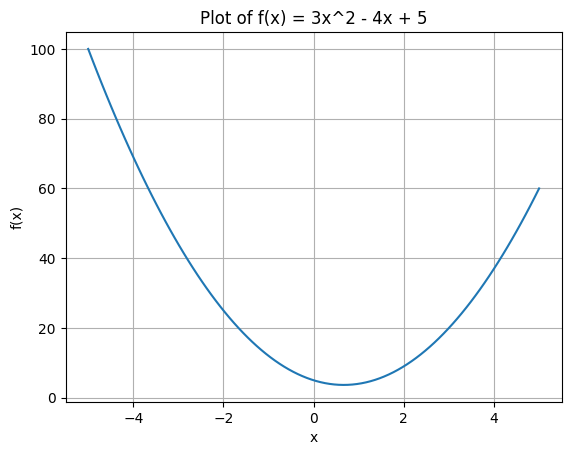

In [4]:
xs = np.linspace(-5, 5, 100)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()
plt.title("Plot of f(x) = 3x^2 - 4x + 5")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

$$\mathbf{f'(x) = 6x - 4}$$

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


$$f'(a) = \lim_{h \to 0} \frac{f(a+h) - f(a)}{h}$$

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

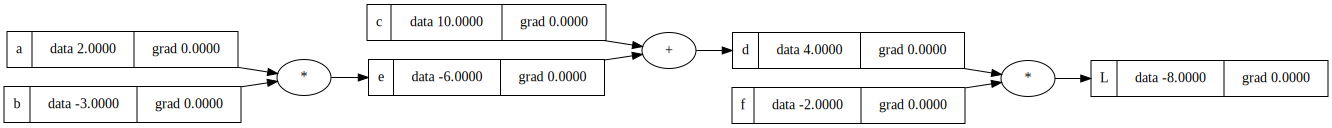

In [11]:
draw_dot(L)

In [12]:
L.backward()

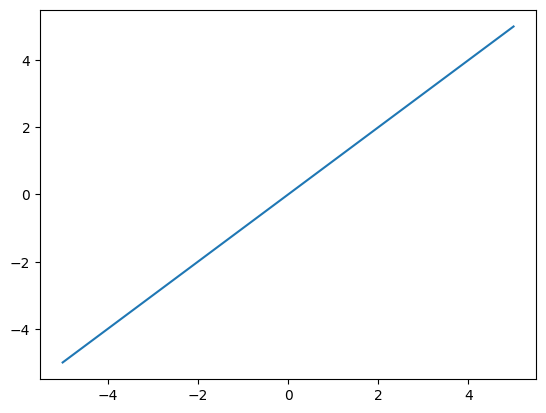

In [13]:
x = np.linspace(-5,5,100)
y = (np.linspace(-5,5,100))
plt.plot(x,y)

In [14]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
    topo.append(v)

In [15]:
build_topo(L)

In [16]:
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=10.0),
 Value(data=4.0),
 Value(data=-2.0),
 Value(data=-8.0)]

In [17]:
import torch


In [18]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [19]:
import random

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
  def __repr__(self):
    return f"Neuron with W:{[self.w[i].data for i in range(len(self.w))]} and Bias {self.b.data})"

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
  def __repr__(self):
    return f"Layer with :{self.neurons})"



class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [20]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [21]:
model = MLP(3, [4,4,1])

In [22]:
for i in range(50):
    pred = [model(row) for row in xs]

    loss = sum([(p-t)**2 for p, t in zip(pred, ys)])

    for param in model.parameters():
        param.grad =0
    
    loss.backward()

    for param in model.parameters():
        param.data += -0.01*param.grad
    
    print(i, loss)

0 Value(data=6.484203827811669)
1 Value(data=6.099291021198868)
2 Value(data=5.642426838003758)
3 Value(data=5.178268233016837)
4 Value(data=4.772671251984639)
5 Value(data=4.4369531605100425)
6 Value(data=4.153617674167705)
7 Value(data=3.9099456705882156)
8 Value(data=3.699296855797904)
9 Value(data=3.516067556648896)
10 Value(data=3.353759639356385)
11 Value(data=3.205102017271074)
12 Value(data=3.062677787336795)
13 Value(data=2.9193024999546204)
14 Value(data=2.76807249455012)
15 Value(data=2.602361688035198)
16 Value(data=2.416219274717232)
17 Value(data=2.2058272910314747)
18 Value(data=1.9726766058030154)
19 Value(data=1.7274547946566785)
20 Value(data=1.4894440375374964)
21 Value(data=1.2773169852148378)
22 Value(data=1.0998065958877798)
23 Value(data=0.9559007685998206)
24 Value(data=0.8401326617667765)
25 Value(data=0.7464505631827368)
26 Value(data=0.6697292061402894)
27 Value(data=0.6060273200700357)
28 Value(data=0.5524169952164788)
29 Value(data=0.5067379165032714)
30 Va